In [1]:
!pip install pystan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.9 MB 24.9 MB/s 
     |████████████████████████████████| 69 kB 8.9 MB/s 
     |████████████████████████████████| 179 kB 60.9 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Successfully uninstalled holidays-0.10.5.2
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 1.0.1 which is incompatible.


<h1>Cài đặt thư viện

Đầu tiên, ta thêm thư viện pandas, numpy và Prophet. 

In [3]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

Thêm thư viện tắt thông báo

In [4]:
import warnings
warnings.simplefilter('ignore')

Thêm thư viện đọc dữ liệu của Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

<h1>Đọc dữ liệu</h1>
Đầu vào của Prophet luôn là một tập dữ liệu với hai thuộc tính là ds và y. trong đó, ds có định dạng ngày, đánh dấu mốc thời gian. Và cột y đại diện cho giá trị định lượng, đại diện cho phép đo mà ta dự đoán.

In [7]:
train_ETH = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/9_1/btc/bitcoin_train_9_1.csv", parse_dates=True, index_col=0)
train_ETH.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-06-01,9.4545,10.3018,9.4297,10.1893,796676,USD
2020-06-02,10.1907,10.2073,9.3473,9.5276,1058556,USD
2020-06-03,9.5270,9.6672,9.4217,9.6672,558116,USD
2020-06-04,9.6672,9.8644,9.4909,9.7944,593664,USD
2020-06-05,9.7940,9.8461,9.6287,9.6312,527054,USD


In [8]:
train = train_ETH[["Open"]]
train.head(5)

,Open
Date,
2020-06-01,9.4545
2020-06-02,10.1907
2020-06-03,9.5270
2020-06-04,9.6672
2020-06-05,9.7940


In [9]:
train = train.reset_index(level=0)
train.columns = ['ds','y']
train.head(5)

,ds,y
0,2020-06-01,9.4545
1,2020-06-02,10.1907
2,2020-06-03,9.5270
3,2020-06-04,9.6672
4,2020-06-05,9.7940


In [10]:
test_ETH = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/9_1/btc/bitcoin_test_9_1.csv", parse_dates=True, index_col=0)
test_ETH.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2022-03-21,41.282,41.5320,40.530,41.022,406616256,USD
2022-03-22,41.022,43.3279,40.893,42.373,537056064,USD
2022-03-23,42.373,43.0270,41.795,42.912,433957536,USD
2022-03-24,42.911,44.2510,42.658,44.013,491663072,USD
2022-03-25,44.013,45.1120,43.622,44.331,494089824,USD


In [11]:
test = test_ETH[["Open"]]
test.head(5)

,Open
Date,
2022-03-21,41.282
2022-03-22,41.022
2022-03-23,42.373
2022-03-24,42.911
2022-03-25,44.013


In [12]:
test = test.reset_index(level=0)
test.columns = ['ds','y']
test.tail(5)

,ds,y
68,2022-05-28,28.6201
69,2022-05-29,29.0271
70,2022-05-30,29.4652
71,2022-05-31,31.7302
72,2022-06-01,31.7931


In [13]:
df = pd.concat([train, test],    # Combine vertically
                          ignore_index = True,
                          sort = False)
df.head(5)    

,ds,y
0,2020-06-01,9.4545
1,2020-06-02,10.1907
2,2020-06-03,9.5270
3,2020-06-04,9.6672
4,2020-06-05,9.7940


In [14]:
df.tail(5)    

,ds,y
726,2022-05-28,28.6201
727,2022-05-29,29.0271
728,2022-05-30,29.4652
729,2022-05-31,31.7302
730,2022-06-01,31.7931


<h1>Trực quan hóa dữ liệu

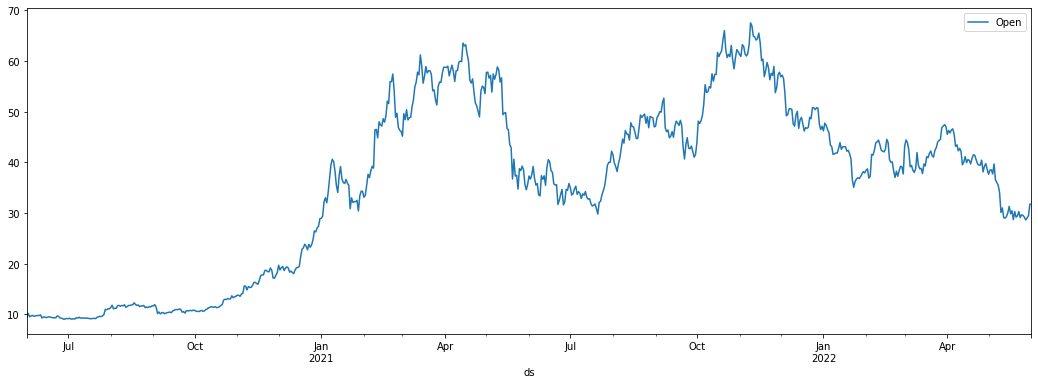

In [15]:
df.plot(x="ds", y='y',figsize=(18,6), label="Open")

<li>Ta xây dựng mô hình thông qua hàm Prophet()

In [16]:
interrupt = len(train)
interrupt

658

In [17]:
# Check size
print(train.shape)  
print(test.shape)  

(658, 2)
(73, 2)


In [18]:
future = df.copy()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


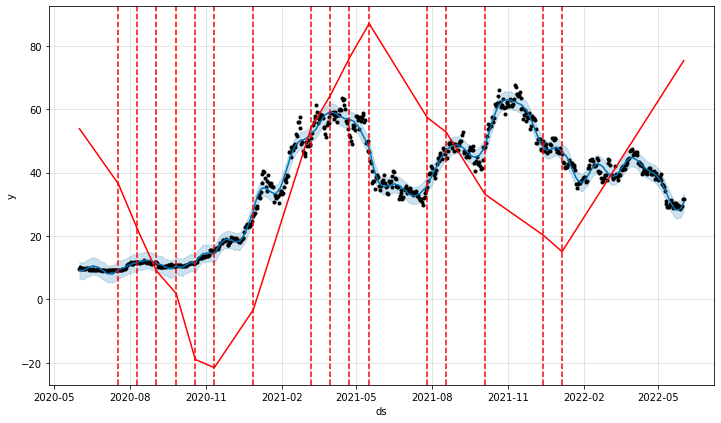

In [19]:
m = Prophet(changepoint_prior_scale=.99)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

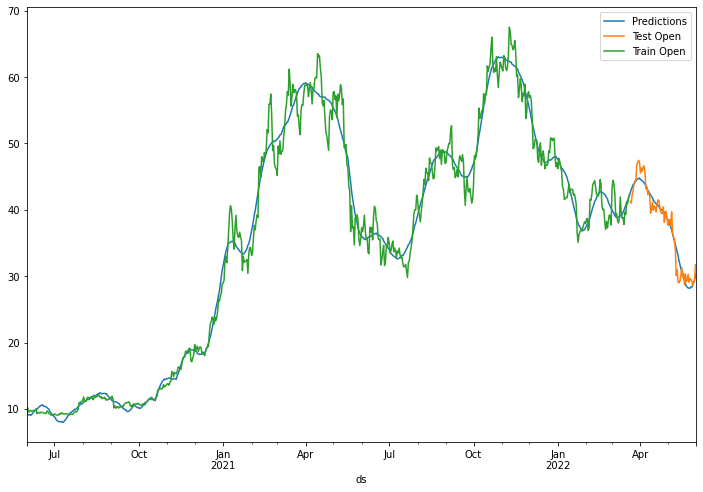

In [20]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))
test.plot(x='ds',y='y',label='Test Open',legend=True,ax=ax)
train.plot(x='ds',y='y',label='Train Open',legend=True,ax=ax)
#,xlim=((datetime.strptime(current_time, '%Y-%m-%d') - timedelta(days = 30)).strftime("%Y-%m-%d"),current_time)

In [21]:
mae = mean_absolute_error(test.y, forecast[interrupt:].yhat)
mape = mean_absolute_percentage_error(test.y, forecast[interrupt:].yhat)
mse = mean_squared_error(test.y, forecast[interrupt:].yhat)
rmse = np.sqrt(mse)
r2 = r2_score(test.y, forecast[interrupt:].yhat)
# print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
# print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAPE: 3.12%
RMSE: 1.49
R2: 0.94
